# Safety Line Data Science & Data Engineering technical test

The main goal of this test is to evaluate the capacity of the candidate to work in the SITA FOR AIRCRAFT Data Science environment.


## Traitement des données et choix des variables  

### 1. Chargement des signaux bruts

J’ai commencé par charger les différents signaux (altitude, vitesse, vent, débit carburant). Chaque signal était dans une dataframe séparée, où :
- les lignes représentent les instants de temps (propres à chaque vol),
- et les colonnes, les vols .

Pour chaque vol, j’ai combiné les signaux en concaténant les données sur l’axe du temps. Avant ça, j’ai supprimé les lignes contenant des valeurs manquantes, pour m'assurer que toutes les grandeurs soient disponibles au même instant pour un vol donné.


### 2. Nettoyage et alignement

Comme les vecteurs temps varient selon les vols, j’ai traité les vols un par un. Pour chaque vol :
- j’ai construit une dataframe avec les quatre signaux,
- supprimé les lignes incomplètes,
- puis j’ai rassemblé tous les segments valides dans un dataset global, en ajoutant un identifiant de vol (`flight_id`) pour garder la traçabilité.


### 3. Filtrage selon les scénarios

#### Étude du débit carburant en fonction de la vitesse (à altitude constante)

J’ai extrait un sous-ensemble de données où l’altitude reste autour de 8000 ft :
- filtre : `altitude ∈ [7900, 8100]`

Ce filtrage permet d’isoler l’effet de la vitesse sur le débit carburant, en réduisant l’influence de l’altitude.

#### Étude du débit carburant en fonction de l’altitude (à vitesse constante)

J’ai aussi extrait un sous-ensemble où la vitesse est maintenue constante autour de 665 km/h :
- filtre : `vitesse ∈ [655, 675]`

Ici, l’objectif c'est d’observer l’effet de l’altitude sur le débit carburant, sans que la vitesse joue un rôle perturbateur.


### 4. Suppression des valeurs aberrantes

Certaines valeurs de débit carburant (par exemple > 1000 lb/s) semblaient extrêmes, probablement dues à des erreurs de capteurs ou de simulation.

Pour fiabiliser l’apprentissage, j’ai utilisé la méthode des quartiles (IQR) :
- j’ai retiré les valeurs supérieures à `Q3 + 1.5 × IQR`

Ce nettoyage rend les données plus cohérentes et les modèles plus lisibles.


### 5. Sélection des variables explicatives

J’ai choisi de ne garder que les variables **physiquement pertinentes** pour expliquer le débit carburant :
- `vitesse` : plus l’avion va vite, plus la poussée nécessaire est grande donc plus de consommation
- `altitude` : elle influence la densité de l’air, donc l'efficacité du moteur

J’ai  **exclu le vent**, car il affecte seulement la vitesse sol (et pas la vitesse propre). Or, le moteur réagit à la vitesse par rapport à l’air, donc inclure le vent reviendrait à ajouter une variable non causale, inutile pour la modélisation.


### 6. Préparation finale

Après le nettoyage et les filtrages :
- j’ai découpé les données en un jeu d’entraînement (80%) et un jeu de test (20%)
- puis j’ai testé plusieurs modèles de régression : linéaire, polynomiale, et forêt aléatoire (la foret est plus performante dans notre cas)

In [1]:
import pandas as pd

altitude_df = pd.read_pickle("signals_altitude.pkl")
fuel_flow_df = pd.read_pickle("signals_fuel_flow.pkl")
speed_df = pd.read_pickle("signals_vitesse.pkl")
wind_df = pd.read_pickle("signals_wind.pkl")

In [2]:
combined_flights = []

for flight in altitude_df.columns:
    try:
        df = pd.concat([
            altitude_df[flight].rename('altitude'),
            speed_df[flight].rename('speed'),
            wind_df[flight].rename('wind'),
            fuel_flow_df[flight].rename('fuel flow')
        ], axis=1).dropna()
        df['flight'] = flight
        combined_flights.append(df)
    except Exception as e:
        print(f"flight {flight} skipped due to missing data")

full_data = pd.concat(combined_flights).reset_index(drop=True)
print(f"Total data points: {len(full_data)}")
full_data.head()

Total data points: 2105


,altitude,speed,wind,fuel flow,flight
0,2000.0,190.0,46.0,0.000532,0
1,2000.0,190.0,46.0,0.000532,0
2,1000.0,855.0,7.0,0.009264,0
3,1000.0,855.0,7.0,0.009264,0
4,1000.0,855.0,7.0,0.009264,0


In [3]:
subset = full_data[(full_data['speed'] >= 655) & (full_data['speed'] <= 675)]

Fuel flow ~ speed model
R^2 score: 0.9995
RMSE: 0.00 lb/s


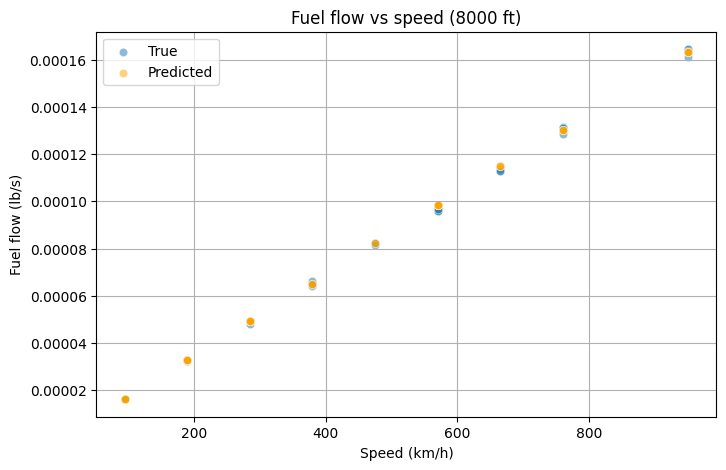

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
# filter: constant altitude 8000 ft ± 100
speed_subset = full_data[(full_data['altitude'] >= 7900) & (full_data['altitude'] <= 8100)]

# regression: fuel flow ~ speed
# cap fuel flow at a reasonable threshold
threshold = 200 
speed_subset = speed_subset[speed_subset['fuel flow'] < threshold]
X = speed_subset[['speed']]
y = speed_subset['fuel flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Fuel flow ~ speed model")
print(f"R^2 score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred):.2f} lb/s")

# plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_test['speed'], y=y_test, label='True', alpha=0.5)
sns.scatterplot(x=X_test['speed'], y=y_pred, label='Predicted', color='orange',alpha=0.5)
plt.title('Fuel flow vs speed (8000 ft)')
plt.xlabel('Speed (km/h)')
plt.ylabel('Fuel flow (lb/s)')
plt.legend()
plt.grid(True)
plt.show()

### pourquoi je n’ai pas inclus la vitesse du vent dans ce modèle


dans ce premier scénario, l’avion est supposé voler à altitude constante, donc en palier. dans ce cas, le bilan des forces s’écrit simplement :  
- la portance compense le poids,  
- la poussée compense la traînée aérodynamique.

la traînée dépend directement de la **vitesse propre**, c’est-à-dire la vitesse de l’avion par rapport à la masse d’air. le moteur fournit juste assez de poussée pour contrer cette traînée, ce qui détermine le **débit de carburant** nécessaire.

le vent, lui, modifie uniquement la **vitesse sol**, c’est-à-dire le déplacement par rapport au sol. comme le moteur "voit" uniquement l’air autour de lui, il ne fait pas de distinction entre un vent de face ou de dos : tant que la vitesse propre reste la même, la poussée (et donc la consommation) reste la même.


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score


X = speed_subset[['speed']]
y = speed_subset['fuel flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Model 1: régression linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Model 2: polynome de degrée 2
poly2 = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly2.fit(X_train, y_train)
y_pred_poly2 = poly2.predict(X_test)

# to compare with random forest
print("Linear regression R^2:", r2_score(y_test, y_pred_lr))
print("Polynomial degree 2 R^2:", r2_score(y_test, y_pred_poly2))

Linear regression R^2: 0.8315787808451695
Polynomial degree 2 R^2: 0.9199251061597868


Fuel flow ~ Altitude model
R^2 score: 0.9999
RMSE: 0.00 lb/s


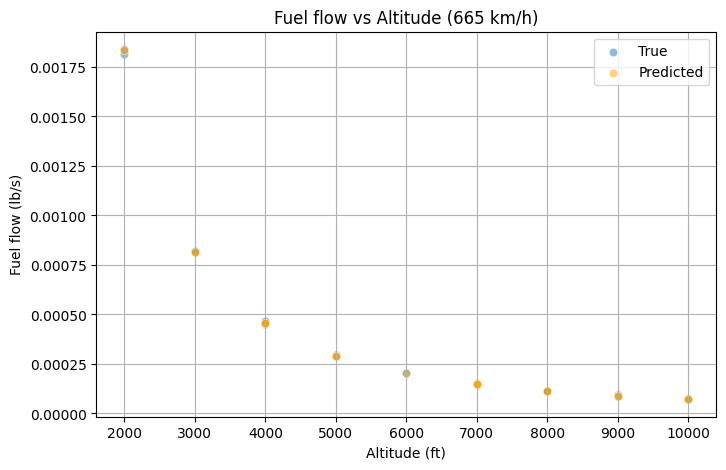

In [6]:
# ------------------------------
# filter: constant speed 665 ± 10
# ------------------------------
alt_subset = full_data[(full_data['speed'] >= 655) & (full_data['speed'] <= 675)]

# ------------------------------
# régression: fuel flow ~ altitude
# ------------------------------
q1 = alt_subset['fuel flow'].quantile(0.25)
q3 = alt_subset['fuel flow'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

alt_subset = alt_subset[alt_subset['fuel flow'] < upper_bound]
X = alt_subset[['altitude']]
y = alt_subset['fuel flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Fuel flow ~ Altitude model")
print(f"R^2 score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred):.2f} lb/s")

# plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_test['altitude'], y=y_test, label='True', alpha=0.5)
sns.scatterplot(x=X_test['altitude'], y=y_pred, label='Predicted', color='orange',alpha=0.5)
plt.title('Fuel flow vs Altitude (665 km/h)')
plt.xlabel('Altitude (ft)')
plt.ylabel('Fuel flow (lb/s)')
plt.legend()
plt.grid(True)
plt.show()

### pourquoi je n’ai pas inclus la vitesse du vent dans ce modèle

dans ce deuxième scénario, la vitesse propre est fixe, donc la traînée reste à peu près constante (en supposant un profil de vol stable). ce qui varie ici, c’est **l’altitude**, donc la **densité de l’air**. comme la poussée nécessaire dépend de cette densité, les moteurs ajustent leur fonctionnement en conséquence : plus l’air est raréfié, plus le régime moteur peut changer pour maintenir la même vitesse.

la variation de la consommation de carburant est donc due à des phénomènes liés à l'altitude (moins d’oxygène, efficacité moteur modifiée, etc.) et pas au vent. encore une fois, le vent n’affecte que la trajectoire sol, pas la physique interne du vol ni les efforts aérodynamiques.

# Bonus

Fuel flow ~ speed + altitude model
R^2 score: 0.9931
RMSE: 0.00 lb/s


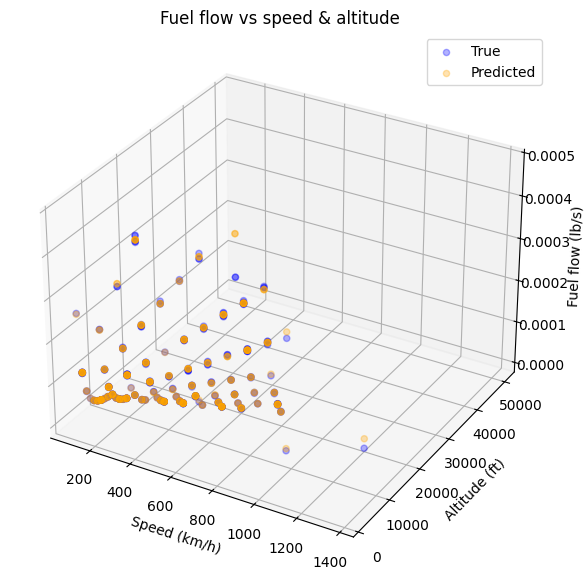

In [22]:
# régression: fuel_flow ~ [speed, altitude]

# on supprime les outliers
q1 = full_data['fuel flow'].quantile(0.25)
q3 = full_data['fuel flow'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

full_data = full_data[full_data['fuel flow'] <= upper_bound]
X = full_data[['speed', 'altitude']]
y = full_data['fuel flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Fuel flow ~ speed + altitude model")
print(f"R^2 score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred):.2f} lb/s")

# 3D plot (avec l'aide de la documentation pour mpl_toolkits que je ne connaissais pas)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['speed'], X_test['altitude'], y_test, c='blue', label='True', alpha=0.3)
ax.scatter(X_test['speed'], X_test['altitude'], y_pred, c='orange', label='Predicted', alpha=0.3)
ax.set_xlabel("Speed (km/h)")
ax.set_ylabel("Altitude (ft)")
ax.set_zlabel("Fuel flow (lb/s)")
ax.set_title("Fuel flow vs speed & altitude")
plt.legend()
plt.show()